## **Lab 4:** Image Classification and Evaluation Metrics

**Objectives**
- Load and preprocess a toy image dataset (e.g., MNIST, Fashion-MNIST, CIFAR-10 subset).
- Train a small convolutional classifier using a high-level deep learning API.
- Implement and compute evaluation metrics: accuracy, precision, recall, F1-score.
- Generate and interpret a confusion matrix.
- Understand trade-offs between metrics when dealing with imbalanced datasets.

**Reading**

- sklearn/PyTorch docs on evaluation metrics.

**Instructions:**
> - Ensure your Python environment is setup correctly, in particular Jupyter package is installed.<br>As we progress through this module, you may be required to install additional packages.
> - Prior to this tutorial, read the entire notebook and attempt all coding exercises.
> - To complete the coding exercises, write some python code between<br>`### INPUT YOUR CODE HERE ###` and `### END OF YOUR CODE SEGMENT ###`.<br> Use provided hints where necessary. We will generally provide a rough estimate of the number of lines to write.
> - Run cells by pressing `Shift+Enter` and verify that your results are consistent with unit tests.
> - Submit completed notebook on VLE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, exposure, transform, filters, util, metrics, feature
import cv2
from scipy.signal import convolve2d
from scipy.ndimage import uniform_filter

import torch
import torch.nn.functional as F
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Expected in:")
warnings.filterwarnings("ignore", message="libtorch_cpu.dylib")

print("Library versions:")
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("cv2:", cv2.__version__)
print("pytorch:", torch.__version__)

# TODO: confirm you can run this cell without errors.

Library versions:
numpy: 2.0.2
matplotlib: 3.10.0
cv2: 4.12.0
pytorch: 2.8.0+cu126


> **Expected Output:**
>
> ``` text
> Library versions:
> numpy: 1.26.4
> matplotlib: 3.7.2
> cv2: 4.10.0
> pytorch: 2.1.0
> ```

---

## <font color='#D85658'>1. Introduction and Setup</font> ##

Import libraries (PyTorch/TensorFlow, matplotlib, sklearn), Load dataset and visualize sample images.

In this section, you will prepare your environment to train and evaluate an image classifier.  
We will:
- Import the necessary libraries (PyTorch, matplotlib, sklearn).  
- Load a small toy image dataset.  
- Visualize sample images to understand the classification task.

Understanding your data before training is an essential first step in any machine learning workflow.

> ### <mark style="background-color: cyan;">Exercise 1:</mark> Import the Required Libraries

In this exercise, you’ll import the key libraries for deep learning, data handling, and visualization.
You will use PyTorch to build the model, matplotlib for visualization, and sklearn for performance metrics.

In [2]:
### START CODE ### (5 lines)
import torch
import numpy as np
# torchvision
from torchvision import datasets, transforms
# transforms
from torch.utils.data import DataLoader
# DataLoader

# --- Visualization and evaluation tools ---
# matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

### END CODE ###

# --- Check environment setup ---
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.8.0+cu126
CUDA available: False


> **Expected Output:**
>
> ``` text
> PyTorch version: 2.1.0
> CUDA available: True
> ```

In [3]:
import random

random.seed(2025)
# --- NumPy ---
np.random.seed(2025)
# --- PyTorch (CPU + GPU) ---
torch.manual_seed(2025)
torch.cuda.manual_seed(2025)

> ### <mark style="background-color: cyan;">Exercise 2:</mark> Load a Toy Image Dataset

We’ll use the CIFAR-10 dataset, which contains 60,000 small 32×32 color images across 10 object categories (e.g., airplane, cat, car).

You’ll download and prepare it for training and testing.

In [4]:
# --- Define preprocessing transforms ---
transform = transforms.Compose([
    transforms.ToTensor(),                     # convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5),      # normalize RGB channels
                         (0.5, 0.5, 0.5))
])

# --- Load CIFAR-10 training and test sets ---
### START CODE ### (4 lines)
trainset = datasets.CIFAR10(root = './data', train=True,
                            download=True, transform=transform) # torchvision CIFAR10 trainset
testset = datasets.CIFAR10(root = './data', train=False,
                           download=True, transform=transform) # torchvision CIFAR10 testset

# --- Create data loaders ---
trainloader = DataLoader(trainset, batch_size=64, shuffle=True) # DataLoader
testloader = DataLoader(testset, batch_size=64, shuffle=False) # DataLoader
### END CODE ###

# --- Class labels ---
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 54.5MB/s]


> ### <mark style="background-color: cyan;">Exercise 3:</mark> Visualize Sample Images

Before training, it’s important to visually inspect your dataset.
Here, we display a few sample images with their corresponding class labels.

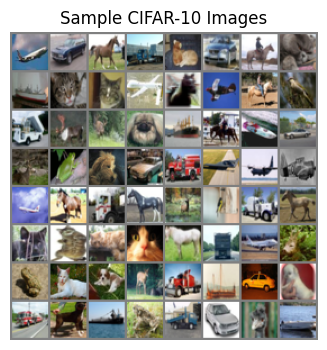

Labels: plane car   horse truck cat   car   horse cat  


In [5]:
import torchvision
# --- Get a batch of training images ---
dataiter = iter(trainloader)
images, labels = next(dataiter)

# --- Convert images from tensors to numpy arrays for plotting ---
def imshow(img):
    ### START CODE ### (2 lines)
    img = img/2+0.5   # unnormalize from [-1,1] back to [0,1]
    npimg = img.numpy() # numpy format
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    ### END CODE ###

# --- Display a grid of sample images ---
plt.figure(figsize=(8, 4))
### START CODE ### (1 line)
imshow(torchvision.utils.make_grid(images)) # use torchvision lib
### END CODE ###
plt.title('Sample CIFAR-10 Images')
plt.show()


# --- Print corresponding class labels ---
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


> **Expected Output:**
>
> <img src="figs-lab4/plot_exercise3.png" alt="Expected Output" width="50%">
>
> ``` text
> Labels: ship  deer  ship  deer  plane ship  truck dog  
> ```

**Comments:**

By completing this section, students will:

- Understand the dataset structure.
- Know how to prepare and visualize images for training.
- Be ready to move on to model definition and training.

---
## <font color='#D85658'>2. Model Training</font> ##

Now that the dataset is loaded, we will:
1. Define a small **Convolutional Neural Network (CNN)** with 2–3 convolutional layers.  
2. Train it on the CIFAR-10 dataset for a few epochs.  
3. Track **training loss and accuracy** to see how the model learns over time.

This section introduces the core workflow of deep learning in PyTorch — model definition, loss computation, optimization, and monitoring performance.

> ### <mark style="background-color: cyan;">Exercise 4:</mark> Define a Small CNN

In this exercise, you’ll define a simple CNN with a few convolutional and pooling layers followed by fully connected layers.

This architecture is small enough to train quickly, but still captures hierarchical visual features.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# --- Define a simple CNN ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

    ### START CODE ### (10 lines)

        # Convolutional block 1: extract low-level features
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # MaxPool2d

        # Convolutional block 2: deeper feature extraction
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(32*8*8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes in CIFAR-10

    def forward(self, x):
        # Forward pass through conv, ReLU, and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 32*8*8)

        # Fully connected layers with ReLU and output logits
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    ### END CODE ###

# --- Instantiate model, loss, and optimizer ---
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


> **Expected Output:**
>
> ``` text
> SimpleCNN(
>   (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
>   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
>   (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
>   (fc1): Linear(in_features=2048, out_features=128, bias=True)
>   (fc2): Linear(in_features=128, out_features=10, bias=True)
> )
> ```

> ### <mark style="background-color: cyan;">Exercise 5:</mark> Train the CNN on the Toy Dataset

Now we’ll train the CNN for a few epochs. We’ll compute the loss and accuracy after each epoch to monitor the learning progress.

In [7]:
from tqdm import tqdm  # progress bar utility

# --- Training loop with progress bar ---
num_epochs = 20
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Wrap the DataLoader with tqdm for batch progress
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    ### START CODE ### (8 lines)

    for images, labels in progress_bar:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update tqdm display
        progress_bar.set_postfix(loss=loss.item())

    # Compute average loss and accuracy
    epoch_loss = running_loss/len(trainloader)
    epoch_acc = 100 * correct/total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    ### END CODE ###

print("✅ Training complete!")

Epoch [1/20] - Loss: 1.4426, Accuracy: 48.06%


Epoch [2/20] - Loss: 1.0856, Accuracy: 61.57%


Epoch [3/20] - Loss: 0.9283, Accuracy: 67.24%


Epoch [4/20] - Loss: 0.8280, Accuracy: 70.75%


Epoch [5/20] - Loss: 0.7462, Accuracy: 73.91%


Epoch [6/20] - Loss: 0.6782, Accuracy: 76.14%


Epoch [7/20] - Loss: 0.6120, Accuracy: 78.72%


Epoch [8/20] - Loss: 0.5491, Accuracy: 80.73%


Epoch [9/20] - Loss: 0.4943, Accuracy: 82.62%


Epoch [10/20] - Loss: 0.4350, Accuracy: 84.64%


Epoch [11/20] - Loss: 0.3823, Accuracy: 86.52%


Epoch [12/20] - Loss: 0.3365, Accuracy: 88.29%


Epoch [13/20] - Loss: 0.2910, Accuracy: 89.78%


Epoch [14/20] - Loss: 0.2519, Accuracy: 91.21%


Epoch [15/20] - Loss: 0.2137, Accuracy: 92.52%


Epoch [16/20] - Loss: 0.1810, Accuracy: 93.75%


Epoch [17/20] - Loss: 0.1532, Accuracy: 94.72%


Epoch [18/20] - Loss: 0.1385, Accuracy: 95.16%


Epoch [19/20] - Loss: 0.1197, Accuracy: 95.84%


Epoch [20/20] - Loss: 0.1123, Accuracy: 96.06%
✅ Training complete!


> **Expected Output:**
>
> ``` text
> Epoch [1/20] - Loss: 1.2610, Accuracy: 54.53%
> Epoch [2/20] - Loss: 0.9295, Accuracy: 67.19%
> Epoch [3/20] - Loss: 0.8007, Accuracy: 71.67%
> Epoch [4/20] - Loss: 0.7030, Accuracy: 75.07%
> Epoch [5/20] - Loss: 0.6188, Accuracy: 78.08%
> Epoch [6/20] - Loss: 0.5460, Accuracy: 80.55%
> Epoch [7/20] - Loss: 0.4806, Accuracy: 82.88%
> Epoch [8/20] - Loss: 0.4178, Accuracy: 85.14%
> Epoch [9/20] - Loss: 0.3687, Accuracy: 86.88%
> Epoch [10/20] - Loss: 0.3224, Accuracy: 88.35%
> Epoch [11/20] - Loss: 0.2864, Accuracy: 89.70%
> Epoch [12/20] - Loss: 0.2548, Accuracy: 90.74%
> Epoch [13/20] - Loss: 0.2303, Accuracy: 91.78%
> Epoch [14/20] - Loss: 0.2113, Accuracy: 92.49%
> Epoch [15/20] - Loss: 0.1911, Accuracy: 93.09%
> Epoch [16/20] - Loss: 0.1759, Accuracy: 93.89%
> Epoch [17/20] - Loss: 0.1662, Accuracy: 94.17%
> Epoch [18/20] - Loss: 0.1635, Accuracy: 94.40%
> Epoch [19/20] - Loss: 0.1548, Accuracy: 94.70%
> Epoch [20/20] - Loss: 0.1479, Accuracy: 95.01%
> ✅ Training complete!
> ```

> ### <mark style="background-color: cyan;">Exercise 6:</mark> Monitor Loss and Accuracy Curves

Visualization helps you understand how your model is learning.

Plotting loss and accuracy over epochs allows you to identify underfitting, overfitting, or optimization issues.

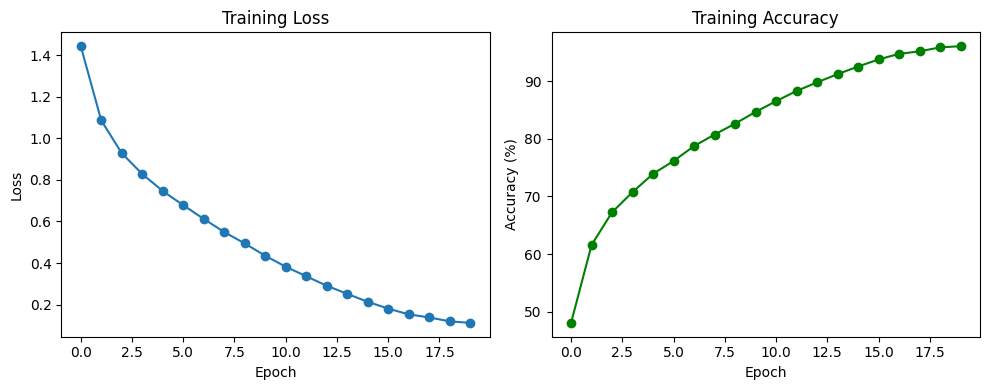

In [8]:
# --- Plot training curves ---
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

> **Expected Output:**
>
> <img src="figs-lab4/plot_exercise6.png" alt="Expected Output" width="50%">

<u>**Comments:**</u>

By completing this section, students will:

- Understand CNN architecture and forward propagation.
- Implement a training loop from scratch.
- Visualize and interpret model learning behavior.


---

## <font color='#D85658'>3. Evaluation Metrics</font> ##

Training accuracy alone doesn't tell the full story of model performance. A model might perform well overall but still make systematic mistakes on certain classes.

In this section, we will:
1. Compute accuracy on the **training and test sets**.  
2. Implement **precision, recall, and F1-score** manually and verify with `sklearn.metrics`.  
3. Prepare for confusion matrix visualization (next exercise).

These metrics are essential for understanding how well your model generalizes and where it fails.

> ### <mark style="background-color: cyan;">Exercise 7:</mark> Compute Accuracy on Train/Test Splits

We'll first measure model accuracy on the training and test datasets to check for overfitting or underfitting.

In [9]:
### START CODE ### (5 lines)

# --- Define evaluation function ---
def evaluate_accuracy(model, dataloader):
    model.eval()  # set to evaluation mode (disable dropout/batchnorm)
    correct, total = 0, 0
    with torch.no_grad():  # no gradient computation
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

### END CODE ###

# --- Compute accuracy on train and test data ---
train_acc = evaluate_accuracy(model, trainloader)
test_acc = evaluate_accuracy(model, testloader)

print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy:     {test_acc:.2f}%")

Training Accuracy: 96.64%
Test Accuracy:     68.40%


> **Expected Output:**
>
> ``` text
> Training Accuracy: 96.46%
> Test Accuracy:     66.36%
> ```

> ### <mark style="background-color: cyan;">Exercise 8:</mark> Implement Precision, Recall, and F1-Score (Manually)

Accuracy can be misleading when classes are imbalanced. Here, we compute precision, recall, and F1-score manually from true positives, false positives, and false negatives.

In [10]:
# --- Collect predictions and ground truths for the test set ---
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        ### START CODE ### (2 lines)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())
        ### END CODE ###

### START CODE ### (2 lines)
# Ensure PyTorch tensors
all_labels = torch.tensor(all_labels)
all_preds = torch.tensor(all_preds)
### END CODE ###

In [11]:

# --- Compute confusion matrix elements per class ---
num_classes = len(torch.unique(all_labels))
TP = torch.zeros(num_classes, dtype=torch.int32)
FP = torch.zeros(num_classes, dtype=torch.int32)
FN = torch.zeros(num_classes, dtype=torch.int32)

### START CODE ### (3 lines)
for c in range(num_classes):
    TP[c] = torch.sum((all_preds == c) & (all_labels == c))
    FP[c] = torch.sum((all_preds == c) & (all_labels != c))
    FN[c] = torch.sum((all_preds != c) & (all_labels == c))
### END CODE ###

### START CODE ### (3 lines)
# --- Compute metrics per class ---
precision = TP / (TP + FP + 1e-8)
recall = TP / (TP + FN + 1e-8)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
### END CODE ###

print("Precision per class:", np.round(precision.numpy(), 2))
print("Recall per class:   ", np.round(recall.numpy(), 2))
print("F1 per class:       ", np.round(f1.numpy(), 2))
print()

### START CODE ### (3 lines)
# Average metrics (macro-averaging)
precision_macro = precision.mean().item()
recall_macro = recall.mean().item()
f1_macro = f1.mean().item()
### END CODE ###

print(f"Macro Precision: {precision_macro:.3f}")
print(f"Macro Recall:    {recall_macro:.3f}")
print(f"Macro F1:        {f1_macro:.3f}")

Precision per class: [0.74 0.84 0.61 0.52 0.59 0.55 0.83 0.75 0.76 0.71]
Recall per class:    [0.7  0.74 0.51 0.5  0.69 0.64 0.68 0.75 0.83 0.8 ]
F1 per class:        [0.72 0.79 0.56 0.51 0.64 0.59 0.74 0.75 0.79 0.75]

Macro Precision: 0.690
Macro Recall:    0.684
Macro F1:        0.684


> **Expected Output:**
>
> ``` text
> Precision per class: [0.74 0.76 0.55 0.46 0.63 0.56 0.7  0.74 0.74 0.76]
> Recall per class:    [0.66 0.78 0.56 0.5  0.55 0.55 0.76 0.74 0.82 0.72]
> F1 per class:        [0.7  0.77 0.55 0.48 0.59 0.55 0.73 0.74 0.78 0.74]
>
> Macro Precision: 0.665
> Macro Recall:    0.664
> Macro F1:        0.663
> ```

> ### <mark style="background-color: cyan;">Exercise 9:</mark> Use sklearn.metrics for Evaluation

Now we'll use `sklearn.metrics` to compute precision, recall, and F1 more accurately for all classes. This is the standard way to evaluate classifiers in practice.

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

### START CODE ### (3 lines)
# --- Compute metrics using sklearn (macro = average over classes) ---
precision_sklearn = precision_score(all_labels, all_preds, average='macro')
recall_sklearn = recall_score(all_labels, all_preds, average='macro')
f1_sklearn = f1_score(all_labels, all_preds, average='macro')
### END CODE ###

print(f"Sklearn Precision (macro): {precision_sklearn:.3f}")
print(f"Sklearn Recall (macro):    {recall_sklearn:.3f}")
print(f"Sklearn F1-score (macro):  {f1_sklearn:.3f}")

# --- Print detailed per-class report ---
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

Sklearn Precision (macro): 0.690
Sklearn Recall (macro):    0.684
Sklearn F1-score (macro):  0.684

Detailed Classification Report:
              precision    recall  f1-score   support

       plane       0.74      0.70      0.72      1000
         car       0.84      0.74      0.79      1000
        bird       0.61      0.51      0.56      1000
         cat       0.52      0.50      0.51      1000
        deer       0.59      0.69      0.64      1000
         dog       0.55      0.64      0.59      1000
        frog       0.83      0.68      0.74      1000
       horse       0.75      0.75      0.75      1000
        ship       0.76      0.83      0.79      1000
       truck       0.71      0.80      0.75      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



> **Expected Output:**
>
> ``` text
> Sklearn Precision (macro): 0.664
> Sklearn Recall (macro):    0.664
> Sklearn F1-score (macro):  0.664
>
> Detailed Classification Report:
>               precision    recall  f1-score   support
>
>        plane       0.59      0.84      0.69      1000
>        plane       0.74      0.66      0.70      1000
>        car         0.76      0.78      0.77      1000
>        bird        0.55      0.56      0.55      1000
>        cat         0.46      0.50      0.48      1000
>        deer        0.63      0.55      0.59      1000
>        dog         0.56      0.55      0.55      1000
>        frog        0.70      0.76      0.73      1000
>        horse       0.74      0.74      0.74      1000
>        ship        0.74      0.82      0.78      1000
>        truck       0.76      0.72      0.74      1000
>
>     accuracy                           0.66     10000
>    macro avg       0.66      0.66      0.66     10000
> weighted avg       0.66      0.66      0.66     10000
> ```

<u>**Reflection**</u>

- How does test accuracy compare to training accuracy? Is there any sign of overfitting?  
- Why might F1-score be more informative than accuracy for unbalanced datasets?  
- Which classes in CIFAR-10 does the model perform best and worst on? Why might that be?  

---

## <font color='#D85658'>4. Experiments</font> ##

In this section, you will explore how data characteristics and augmentation affect classification performance.

We will:
1. Compare model performance on **balanced vs. imbalanced subsets** of the dataset.  
2. Evaluate how **data augmentation** (e.g., rotations, noise) impacts model robustness.

These experiments help you understand why dataset design and augmentation strategies are critical in real-world AI systems.

> ### <mark style="background-color: cyan;">Exercise 10:</mark> Compare Balanced vs. Imbalanced Subsets

Here, we'll create two datasets — one balanced and one intentionally imbalanced — and observe how model performance changes. The goal is to show how imbalance can bias the classifier toward over-represented classes.

In [13]:
from torch.utils.data import Subset

# --- Select a few classes to keep things small ---
selected_classes = [0, 1, 2, 3]  # plane, car, bird, cat

### START CODE ### (2 lines)
# --- Get indices for each selected class ---
indices_by_class = {c: np.where(np.array(trainset.targets) == c)[0]
                    for c in selected_classes}
### END CODE ###

### START CODE ### (2 lines

# --- Create a balanced subset (equal samples per class) ---
n_samples = 500
balanced_indices = np.concatenate([
    indices_by_class[c][:n_samples] for c in selected_classes
])
### END CODE ###

### START CODE ### (4 lines)
# --- Create an imbalanced subset (one class dominates) ---
imbalanced_indices = np.concatenate([
    indices_by_class[0][:1000],    # plane 1000
    indices_by_class[1][:300],    # car 300
    indices_by_class[2][:200],    # bird 200
    indices_by_class[3][:500],    # cat 500
])
### END CODE ###

### START CODE ### (2 lines)
# --- Subset datasets ---
balanced_subset = Subset(trainset, balanced_indices)
imbalanced_subset = Subset(trainset, imbalanced_indices)
### END CODE ###

# --- Create dataloaders ---
balanced_loader = DataLoader(balanced_subset, batch_size=16, shuffle=True)
imbalanced_loader = DataLoader(imbalanced_subset, batch_size=16, shuffle=True)

print(f"Balanced subset size:   {len(balanced_subset)}")
print(f"Imbalanced subset size: {len(imbalanced_subset)}")

Balanced subset size:   2000
Imbalanced subset size: 2000


> **Expected Output:**
> ``` text
> Balanced subset size:   2000
> Imbalanced subset size: 2000
> ```










#### Train and Evaluate on Balanced vs. Imbalanced Sets

Now we train the same CNN `SimpleCNN` on both balanced and imbalanced training subsets, then evaluate their performance on a common test set to see how class imbalance impacts generalization.

In [14]:
# --- Define a quick training utility function ---
def quick_train(model, dataloader, epochs=3):
    """Train a small CNN for a few epochs and return the trained model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0

        # Wrap the DataLoader with tqdm for batch progress
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        ### START CODE ### (8 lines)
        for images, labels in progress_bar:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward() # backward
            optimizer.step() # optimizer

            # Update metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {running_loss/len(dataloader):.3f} | "
              f"Accuracy: {100*correct/total:.2f}%")
        ### END CODE ###

    return model

In [15]:
# --- Train on the balanced dataset ---
print("\n🔹 Training on Balanced Dataset")
balanced_model = SimpleCNN()
balanced_model = quick_train(balanced_model, balanced_loader, epochs=15)

# --- Train on the imbalanced dataset ---
print("\n🔸 Training on Imbalanced Dataset")
imbalanced_model = SimpleCNN()
imbalanced_model = quick_train(imbalanced_model, imbalanced_loader, epochs=15)


🔹 Training on Balanced Dataset


Epoch 1/15 - Loss: 1.248 | Accuracy: 45.95%


Epoch 2/15 - Loss: 0.892 | Accuracy: 64.50%


Epoch 3/15 - Loss: 0.735 | Accuracy: 72.15%


Epoch 4/15 - Loss: 0.681 | Accuracy: 74.10%


Epoch 5/15 - Loss: 0.606 | Accuracy: 76.25%


Epoch 6/15 - Loss: 0.530 | Accuracy: 80.05%


Epoch 7/15 - Loss: 0.492 | Accuracy: 81.50%


Epoch 8/15 - Loss: 0.445 | Accuracy: 83.15%


Epoch 9/15 - Loss: 0.385 | Accuracy: 85.35%


Epoch 10/15 - Loss: 0.329 | Accuracy: 87.60%


Epoch 11/15 - Loss: 0.269 | Accuracy: 89.80%


Epoch 12/15 - Loss: 0.229 | Accuracy: 91.70%


Epoch 13/15 - Loss: 0.205 | Accuracy: 92.20%


Epoch 14/15 - Loss: 0.158 | Accuracy: 94.50%


Epoch 15/15 - Loss: 0.147 | Accuracy: 95.50%

🔸 Training on Imbalanced Dataset


Epoch 1/15 - Loss: 1.001 | Accuracy: 61.10%


Epoch 2/15 - Loss: 0.686 | Accuracy: 73.55%


Epoch 3/15 - Loss: 0.603 | Accuracy: 76.30%


Epoch 4/15 - Loss: 0.545 | Accuracy: 79.65%


Epoch 5/15 - Loss: 0.488 | Accuracy: 82.10%


Epoch 6/15 - Loss: 0.428 | Accuracy: 84.00%


Epoch 7/15 - Loss: 0.372 | Accuracy: 86.65%


Epoch 8/15 - Loss: 0.324 | Accuracy: 88.35%


Epoch 9/15 - Loss: 0.300 | Accuracy: 89.55%


Epoch 10/15 - Loss: 0.250 | Accuracy: 90.75%


Epoch 11/15 - Loss: 0.206 | Accuracy: 92.75%


Epoch 12/15 - Loss: 0.170 | Accuracy: 94.25%


Epoch 13/15 - Loss: 0.128 | Accuracy: 95.85%


Epoch 14/15 - Loss: 0.090 | Accuracy: 97.40%


Epoch 15/15 - Loss: 0.077 | Accuracy: 97.55%


> **Expected Output:**
>
> ``` text
> 🔹 Training on Balanced Dataset
> Epoch 1/15 - Loss: 1.172 | Accuracy: 50.35%
> Epoch 2/15 - Loss: 0.821 | Accuracy: 68.00%
> Epoch 3/15 - Loss: 0.696 | Accuracy: 72.90%
> Epoch 4/15 - Loss: 0.608 | Accuracy: 77.60%
> Epoch 5/15 - Loss: 0.551 | Accuracy: 78.65%
> Epoch 6/15 - Loss: 0.497 | Accuracy: 81.40%
> Epoch 7/15 - Loss: 0.472 | Accuracy: 81.30%
> Epoch 8/15 - Loss: 0.410 | Accuracy: 84.35%
> Epoch 9/15 - Loss: 0.347 | Accuracy: 87.45%
> Epoch 10/15 - Loss: 0.297 | Accuracy: 89.25%
> Epoch 11/15 - Loss: 0.254 | Accuracy: 90.65%
> Epoch 12/15 - Loss: 0.212 | Accuracy: 92.40%
> Epoch 13/15 - Loss: 0.173 | Accuracy: 94.40%
> Epoch 14/15 - Loss: 0.141 | Accuracy: 95.05%
> Epoch 15/15 - Loss: 0.122 | Accuracy: 95.90%
>
> 🔸 Training on Imbalanced Dataset
> Epoch 1/15 - Loss: 0.835 | Accuracy: 64.80%
> Epoch 2/15 - Loss: 0.525 | Accuracy: 77.10%
> Epoch 3/15 - Loss: 0.440 | Accuracy: 81.80%
> Epoch 4/15 - Loss: 0.423 | Accuracy: 83.40%
> Epoch 5/15 - Loss: 0.363 | Accuracy: 85.75%
> Epoch 6/15 - Loss: 0.318 | Accuracy: 87.70%
> Epoch 7/15 - Loss: 0.291 | Accuracy: 88.80%
> Epoch 8/15 - Loss: 0.258 | Accuracy: 90.05%
> Epoch 9/15 - Loss: 0.205 | Accuracy: 92.40%
> Epoch 10/15 - Loss: 0.181 | Accuracy: 93.10%
> Epoch 11/15 - Loss: 0.144 | Accuracy: 94.75%
> Epoch 12/15 - Loss: 0.104 | Accuracy: 96.80%
> Epoch 13/15 - Loss: 0.099 | Accuracy: 96.55%
> Epoch 14/15 - Loss: 0.054 | Accuracy: 98.40%
> Epoch 15/15 - Loss: 0.047 | Accuracy: 98.55%
> ```

#### Evaluate Both Models on the Same Test Set

To fairly compare generalization, we evaluate both trained models on the same test data. This reveals how imbalance affects overall accuracy and per-class performance.

In [16]:
### START CODE ### (3 lines)
n_samples = 200
indices_by_class_test = {c: np.where(np.array(testset.targets) == c)
[0] for c in selected_classes}
balanced_indices_test = np.concatenate([
    indices_by_class_test[c][:n_samples] for c in selected_classes
])
balanced_subset_test = Subset(testset, balanced_indices_test)
sub_testloader = DataLoader(balanced_subset_test, batch_size=8, shuffle=False, num_workers=2)
### END CODE ###

In [17]:
def evaluate_model(model, dataloader, name="Model"):
    """Compute overall test accuracy."""
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            ### START CODE ### (4 lines)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())
            ### END CODE ###

    acc = 100 * correct / total
    print(f"{name} - Test Accuracy: {acc:.2f}%")
    return all_labels, all_preds, acc

# --- Evaluate both models on test set ---
labels_bal, preds_bal, acc_bal = evaluate_model(balanced_model, sub_testloader, "Balanced Model")
labels_imb, preds_imb, acc_imb = evaluate_model(imbalanced_model, sub_testloader, "Imbalanced Model")

Balanced Model - Test Accuracy: 71.25%
Imbalanced Model - Test Accuracy: 72.00%


> **Expected Output:**
> ``` text
> Balanced Model - Test Accuracy: 75.38%
> Imbalanced Model - Test Accuracy: 58.38%
> ```

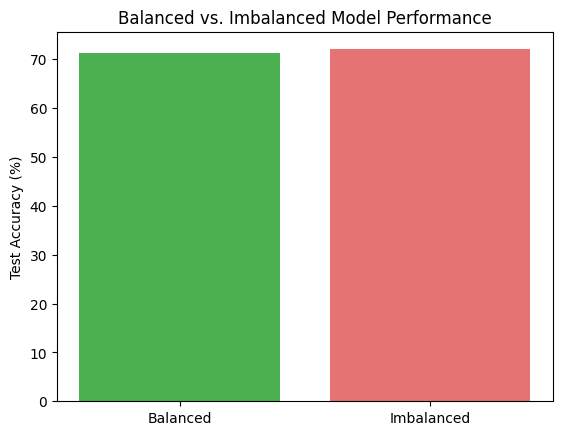

In [18]:
# --- Plot comparison ---
plt.bar(["Balanced", "Imbalanced"], [acc_bal, acc_imb], color=["#4CAF50", "#E57373"])
plt.ylabel("Test Accuracy (%)")
plt.title("Balanced vs. Imbalanced Model Performance")
plt.show()

> **Expected Output:**
>
> <img src="figs-lab4/plot_exercise10.png" alt="Expected Output" width="30%">

> ### <mark style="background-color: cyan;">Exercise 11:</mark> Evaluate Classifier under Data Augmentation

Data augmentation artificially expands the dataset by applying random transformations like rotations, flips, and noise. This improves robustness and reduces overfitting.

In [19]:
import torchvision.transforms as transforms

### START CODE ### (3 lines)
# --- Define augmentation transforms ---
augment_transform = transforms.Compose([
    transforms.RandomRotation(20),      # rotate image randomly up to ±20 degrees
    transforms.RandomHorizontalFlip(),      # randomly flip horizontally
    transforms.ColorJitter(brightness=0.2),      # vary brightness
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
### END CODE ###

### START CODE ### (1 line)
# --- Create augmented dataset ---
augmented_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True,
                                                  transform=augment_transform)
### END CODE ###
augmented_loader = DataLoader(augmented_trainset, batch_size=32, shuffle=True)

# --- Train a new CNN on augmented data ---
print("\nTraining with Data Augmentation")
aug_model = SimpleCNN()
aug_model = quick_train(aug_model, augmented_loader, epochs=num_epochs)


Training with Data Augmentation


Epoch 1/20 - Loss: 1.494 | Accuracy: 46.29%


Epoch 2/20 - Loss: 1.202 | Accuracy: 57.38%


Epoch 3/20 - Loss: 1.091 | Accuracy: 61.34%


Epoch 4/20 - Loss: 1.019 | Accuracy: 64.24%


Epoch 5/20 - Loss: 0.970 | Accuracy: 65.89%


Epoch 6/20 - Loss: 0.936 | Accuracy: 67.10%


Epoch 7/20 - Loss: 0.905 | Accuracy: 68.12%


Epoch 8/20 - Loss: 0.883 | Accuracy: 68.71%


Epoch 9/20 - Loss: 0.863 | Accuracy: 69.61%


Epoch 10/20 - Loss: 0.836 | Accuracy: 70.60%


Epoch 11/20 - Loss: 0.826 | Accuracy: 70.93%


Epoch 12/20 - Loss: 0.812 | Accuracy: 71.38%


Epoch 13/20 - Loss: 0.799 | Accuracy: 72.01%


Epoch 14/20 - Loss: 0.782 | Accuracy: 72.48%


Epoch 15/20 - Loss: 0.771 | Accuracy: 72.81%


Epoch 16/20 - Loss: 0.764 | Accuracy: 73.13%


Epoch 17/20 - Loss: 0.753 | Accuracy: 73.34%


Epoch 18/20 - Loss: 0.746 | Accuracy: 73.66%


Epoch 19/20 - Loss: 0.736 | Accuracy: 73.99%


Epoch 20/20 - Loss: 0.733 | Accuracy: 74.20%


> **Expected Output:**
>
> ``` text
> Training with Data Augmentation
> Epoch 1/20 - Loss: 1.497 | Accuracy: 45.73%
> Epoch 2/20 - Loss: 1.183 | Accuracy: 57.53%
> Epoch 3/20 - Loss: 1.069 | Accuracy: 62.12%
> Epoch 4/20 - Loss: 1.009 | Accuracy: 64.49%
> Epoch 5/20 - Loss: 0.960 | Accuracy: 65.95%
> Epoch 6/20 - Loss: 0.924 | Accuracy: 67.53%
> Epoch 7/20 - Loss: 0.891 | Accuracy: 68.72%
> Epoch 8/20 - Loss: 0.868 | Accuracy: 69.53%
> Epoch 9/20 - Loss: 0.851 | Accuracy: 69.69%
> Epoch 10/20 - Loss: 0.833 | Accuracy: 70.63%
> Epoch 11/20 - Loss: 0.816 | Accuracy: 71.33%
> Epoch 12/20 - Loss: 0.804 | Accuracy: 71.63%
> Epoch 13/20 - Loss: 0.797 | Accuracy: 71.88%
> Epoch 14/20 - Loss: 0.786 | Accuracy: 72.47%
> Epoch 15/20 - Loss: 0.773 | Accuracy: 72.87%
> Epoch 16/20 - Loss: 0.768 | Accuracy: 73.08%
> Epoch 17/20 - Loss: 0.755 | Accuracy: 73.25%
> Epoch 18/20 - Loss: 0.753 | Accuracy: 73.50%
> Epoch 19/20 - Loss: 0.746 | Accuracy: 73.65%
> Epoch 20/20 - Loss: 0.742 | Accuracy: 73.89%
> ```

#### Add Random Noise to Test Images

To test robustness, we can evaluate how the trained models handle noisy inputs.

In [20]:
# --- Function to evaluate a model on the full test set ---
def evaluate_on_testloader(model, dataloader, name="Model"):
    """Evaluate model accuracy on the entire test set."""
    model.eval()
    correct, total = 0, 0
    ### START CODE ### (4 lines)
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"{name} - Test Accuracy: {acc:.2f}%")
    return acc
    ### END CODE ###

# --- Evaluate both models on the test set ---
print("✅ Evaluating Models on Test Set...")
acc_base = evaluate_on_testloader(model, testloader, name="Baseline Model")
acc_aug = evaluate_on_testloader(aug_model, testloader, name="Augmented Model")

✅ Evaluating Models on Test Set...
Baseline Model - Test Accuracy: 68.40%
Augmented Model - Test Accuracy: 73.64%


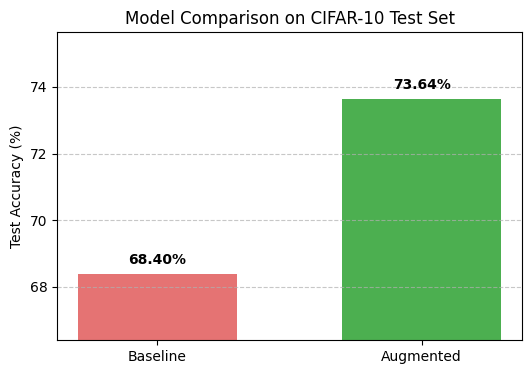

In [21]:
# --- Compare results visually ---
plt.figure(figsize=(6, 4))
bars = plt.bar(["Baseline", "Augmented"], [acc_base, acc_aug],
               color=["#E57373", "#4CAF50"], width=0.6)

plt.ylabel("Test Accuracy (%)")
plt.ylim(min(acc_base, acc_aug)-2, max(acc_base, acc_aug)+2)  # focus on a suitable accuracy range
plt.title("Model Comparison on CIFAR-10 Test Set")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Add numeric accuracy labels on top of each bar ---
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,
             f"{height:.2f}%", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

> **Expected Output:**
>
> <img src="figs-lab4/plot_exercise11.png" alt="Expected Output" width="30%">

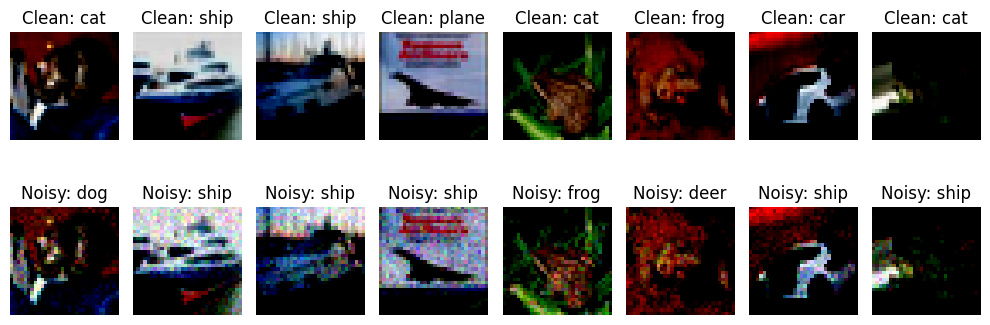

In [23]:
from skimage.util import random_noise

### START CODE ### (5 lines)

# --- Take a batch of test images and add noise ---
dataiter = iter(testloader)
images, labels = next(dataiter)
noisy_images = torch.tensor(np.clip(random_noise(images.numpy(), mode='gaussian',
                                                 var=0.01), 0,1),
                            dtype=torch.float32)

# --- Compare model predictions ---
model.eval()
outputs_clean = model(images)
outputs_noisy = model(noisy_images)

_, pred_clean = torch.max(outputs_clean, 1)
_, pred_noisy = torch.max(outputs_noisy, 1)

### END CODE ###

# --- Display a few comparisons ---
fig, axes = plt.subplots(2, 8, figsize=(10, 4))
for i in range(8):
    axes[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    axes[0, i].set_title(f"Clean: {classes[pred_clean[i]]}")
    axes[0, i].axis("off")

    axes[1, i].imshow(np.transpose(noisy_images[i].numpy(), (1, 2, 0)))
    axes[1, i].set_title(f"Noisy: {classes[pred_noisy[i]]}")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

<u>**Reflection**</u>

* **How does training on imbalanced data affect model accuracy across classes?**
  Ans: When data is imbalanced, the model tends to favor the majority classes, leading to high overall accuracy but poor performance on underrepresented ones. As a result, minority classes often show lower recall and F1-scores.

* **What improvements do you observe when using data augmentation?**
  Ans: With augmentation, the model’s predictions become more consistent and less sensitive to small changes or noise. It generalizes better and shows reduced overfitting, since it is exposed to a wider variety of examples during training.

* **Why does augmentation make models more robust to noise and distortions?**
  Ans: Augmentation mimics real-world variability—changes in lighting, angles, or small distortions—so the model learns to focus on meaningful patterns rather than specific pixel arrangements. This exposure helps it handle new, unseen perturbations more effectively.

* **In a real-world scenario, how would you handle a severely imbalanced dataset?**
  Ans: To tackle imbalance, one can:

  * **Resample** the data by oversampling minority classes or undersampling majority ones.
  * **Adjust the loss function** using weighted cross-entropy or focal loss to emphasize minority classes.
  * **Use ensemble approaches** that combine multiple balanced models for better overall performance.
  * **Adopt suitable metrics** like macro F1-score or precision–recall curves, which give a fairer view of performance across all classes.


---

## <font color='#D85658'>5. Exercises</font> ##

In this final section, you'll apply what you've learned to extend and analyze CNN models.  
You will:

1. Modify the CNN architecture and observe how performance changes.  
2. Train on a binary classification subset to explore precision–recall trade-offs.  
3. Discuss why high accuracy doesn’t always mean good performance.

These exercises will help you connect architectural design, dataset setup, and metric interpretation.

> ### <mark style="background-color: cyan;">Exercise 12:</mark> Modify the CNN and Compare Performance

In this exercise, you'll modify the CNN by adding dropout layers and changing filter sizes. You'll compare the model’s performance before and after modification to see the effect on overfitting and generalization.

In [24]:
# --- Define a modified CNN with dropout and larger filters ---
class ModifiedCNN(nn.Module):
    ### START CODE ### (10 lines)
    def __init__(self):
        super(ModifiedCNN, self).__init__()

        # Larger kernels and dropout regularization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2) # Conv2d
        self.pool = nn.MaxPool2d(2,2)  # MaxPool2d
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2) # Conv2d
        self.dropout = nn.Dropout(p=0.5)  # Dropout - helps prevent overfitting
        self.fc1 = nn.Linear(64*8*8, 256) # Linear
        self.fc2 = nn.Linear(256, 10) # Linear

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # pool conv1
        x = self.pool(F.relu(self.conv2(x))) # pool conv2
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x))) # dropout
        x = self.fc2(x) # fc2
        return x
    ### END CODE ###

# --- Train and evaluate the modified CNN ---
mod_model = ModifiedCNN()
print("Training Modified CNN (with Dropout & Larger Filters):")
mod_model = quick_train(mod_model, trainloader, epochs=num_epochs)

# --- Evaluate on test set ---
_, _, acc_mod = evaluate_model(mod_model, testloader, name="Modified CNN")

Training Modified CNN (with Dropout & Larger Filters):


Epoch 1/20 - Loss: 1.435 | Accuracy: 48.08%


Epoch 2/20 - Loss: 1.086 | Accuracy: 61.73%


Epoch 3/20 - Loss: 0.941 | Accuracy: 67.04%


Epoch 4/20 - Loss: 0.838 | Accuracy: 70.54%


Epoch 5/20 - Loss: 0.762 | Accuracy: 73.40%


Epoch 6/20 - Loss: 0.694 | Accuracy: 75.54%


Epoch 7/20 - Loss: 0.637 | Accuracy: 77.58%


Epoch 8/20 - Loss: 0.587 | Accuracy: 79.42%


Epoch 9/20 - Loss: 0.545 | Accuracy: 80.59%


Epoch 10/20 - Loss: 0.493 | Accuracy: 82.44%


Epoch 11/20 - Loss: 0.453 | Accuracy: 83.69%


Epoch 12/20 - Loss: 0.424 | Accuracy: 84.59%


Epoch 13/20 - Loss: 0.397 | Accuracy: 85.46%


Epoch 14/20 - Loss: 0.369 | Accuracy: 86.56%


Epoch 15/20 - Loss: 0.353 | Accuracy: 87.19%


Epoch 16/20 - Loss: 0.337 | Accuracy: 87.73%


Epoch 17/20 - Loss: 0.310 | Accuracy: 88.69%


Epoch 18/20 - Loss: 0.301 | Accuracy: 89.06%


Epoch 19/20 - Loss: 0.286 | Accuracy: 89.51%


Epoch 20/20 - Loss: 0.272 | Accuracy: 90.12%
Modified CNN - Test Accuracy: 73.17%


> **Expected Output:**
>
> ``` text
> Training Modified CNN (with Dropout & Larger Filters):
> Epoch 1/20:   0%|          | 0/6250 [00:00<?, ?it/s]
> Epoch 1/20 - Loss: 1.437 | Accuracy: 48.08%
> Epoch 2/20 - Loss: 1.138 | Accuracy: 60.32%
> Epoch 3/20 - Loss: 1.033 | Accuracy: 63.76%
> Epoch 4/20 - Loss: 0.950 | Accuracy: 66.75%
> Epoch 5/20 - Loss: 0.893 | Accuracy: 68.81%
> Epoch 6/20 - Loss: 0.837 | Accuracy: 70.78%
> Epoch 7/20 - Loss: 0.796 | Accuracy: 72.10%
> Epoch 8/20 - Loss: 0.745 | Accuracy: 74.19%
> Epoch 9/20 - Loss: 0.713 | Accuracy: 75.29%
> Epoch 10/20 - Loss: 0.669 | Accuracy: 76.49%
> Epoch 11/20 - Loss: 0.636 | Accuracy: 77.84%
> Epoch 12/20 - Loss: 0.612 | Accuracy: 78.59%
> Epoch 13/20 - Loss: 0.585 | Accuracy: 79.69%
> Epoch 14/20 - Loss: 0.549 | Accuracy: 80.91%
> Epoch 15/20 - Loss: 0.531 | Accuracy: 81.63%
> Epoch 16/20 - Loss: 0.508 | Accuracy: 82.46%
> Epoch 17/20 - Loss: 0.490 | Accuracy: 82.90%
> Epoch 18/20 - Loss: 0.487 | Accuracy: 83.36%
> Epoch 19/20 - Loss: 0.472 | Accuracy: 83.98%
> Epoch 20/20 - Loss: 0.456 | Accuracy: 84.38%
> Modified CNN - Test Accuracy: 68.35%
> ```

> ### <mark style="background-color: cyan;">Exercise 13:</mark> Train on a Binary Classification Subset

Now we simplify the problem to binary classification — e.g., distinguishing "cat" vs. "dog" in CIFAR-10.
We'll train and analyze how metrics like precision, recall, and F1 behave compared to overall accuracy.

In [ ]:
# reload trainset if any errors from dataloader
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

In [25]:
### START CODE ### (3 lines)

# --- Choose two CIFAR-10 classes (cat=3, dog=5) ---
binary_classes = [3, 5]
indices = [i for i, label in enumerate(trainset.targets) if label in binary_classes]

# --- Create a binary subset ---
binary_subset = Subset(trainset, indices)
binary_loader = DataLoader(binary_subset, batch_size=32, shuffle=True)

# --- Modify dataset labels to 0/1 for binary classification ---
def relabel_binary(dataset, classes):
    for i in range(len(dataset)):
        img, label = dataset[i]
        dataset.dataset.targets[dataset.indices[i]] = 0 if label == classes[0] else 1 # Modify dataset labels to 0/1

relabel_binary(binary_subset, binary_classes)

### END CODE ###

# --- Train a new CNN on binary data ---
print("\nTraining Binary Classifier (Cat vs Dog):")
binary_model = SimpleCNN()
binary_model = quick_train(binary_model, binary_loader, epochs=num_epochs)


Training Binary Classifier (Cat vs Dog):


Epoch 1/20 - Loss: 0.664 | Accuracy: 62.06%


Epoch 2/20 - Loss: 0.575 | Accuracy: 69.94%


Epoch 3/20 - Loss: 0.534 | Accuracy: 73.22%


Epoch 4/20 - Loss: 0.506 | Accuracy: 75.46%


Epoch 5/20 - Loss: 0.474 | Accuracy: 76.84%


Epoch 6/20 - Loss: 0.453 | Accuracy: 78.20%


Epoch 7/20 - Loss: 0.423 | Accuracy: 80.42%


Epoch 8/20 - Loss: 0.396 | Accuracy: 81.68%


Epoch 9/20 - Loss: 0.361 | Accuracy: 83.31%


Epoch 10/20 - Loss: 0.336 | Accuracy: 84.80%


Epoch 11/20 - Loss: 0.299 | Accuracy: 86.89%


Epoch 12/20 - Loss: 0.273 | Accuracy: 88.44%


Epoch 13/20 - Loss: 0.243 | Accuracy: 89.58%


Epoch 14/20 - Loss: 0.199 | Accuracy: 91.76%


Epoch 15/20 - Loss: 0.170 | Accuracy: 93.46%


Epoch 16/20 - Loss: 0.148 | Accuracy: 94.02%


Epoch 17/20 - Loss: 0.106 | Accuracy: 96.23%


Epoch 18/20 - Loss: 0.086 | Accuracy: 97.28%


Epoch 19/20 - Loss: 0.061 | Accuracy: 98.19%


Epoch 20/20 - Loss: 0.055 | Accuracy: 98.15%


> **Expected Output:**
>
> ``` text
> Training Binary Classifier (Cat vs Dog):
> Epoch 1/20 - Loss: 0.679 | Accuracy: 60.99%
> Epoch 2/20 - Loss: 0.604 | Accuracy: 67.54%
> Epoch 3/20 - Loss: 0.560 | Accuracy: 71.86%
> Epoch 4/20 - Loss: 0.520 | Accuracy: 73.71%
> Epoch 5/20 - Loss: 0.494 | Accuracy: 76.01%
> Epoch 6/20 - Loss: 0.470 | Accuracy: 77.61%
> Epoch 7/20 - Loss: 0.441 | Accuracy: 78.88%
> Epoch 8/20 - Loss: 0.419 | Accuracy: 80.40%
> Epoch 9/20 - Loss: 0.386 | Accuracy: 82.40%
> Epoch 10/20 - Loss: 0.350 | Accuracy: 84.50%
> Epoch 11/20 - Loss: 0.321 | Accuracy: 85.94%
> Epoch 12/20 - Loss: 0.292 | Accuracy: 87.00%
> Epoch 13/20 - Loss: 0.257 | Accuracy: 88.93%
> Epoch 14/20 - Loss: 0.229 | Accuracy: 90.21%
> Epoch 15/20 - Loss: 0.193 | Accuracy: 92.05%
> Epoch 16/20 - Loss: 0.166 | Accuracy: 93.37%
> Epoch 17/20 - Loss: 0.139 | Accuracy: 94.71%
> Epoch 18/20 - Loss: 0.104 | Accuracy: 96.37%
> Epoch 19/20 - Loss: 0.087 | Accuracy: 96.93%
> Epoch 20/20 - Loss: 0.060 | Accuracy: 98.10%
> ```

#### Evaluate Binary Model and Analyse Metric Trade-Offs

In [26]:
### START CODE ### (2 lines)
# --- Create a binary test subset ---
test_indices = [i for i,label in enumerate(testset.targets) if label in binary_classes]
binary_testset = Subset(testset, test_indices)
binary_testloader = DataLoader(binary_testset, batch_size=32, shuffle=False)
### END CODE ###

In [27]:
# --- Relabel test subset to 0/1 for binary classification ---
relabel_binary(binary_testset, binary_classes)

Binary Model - Test Accuracy: 73.90%
Accuracy:  73.90%
Precision: 0.727
Recall:    0.765
F1-Score:  0.746


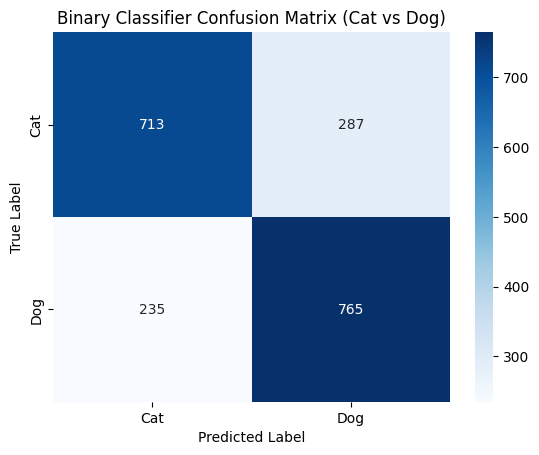

In [28]:
import seaborn as sns

### START CODE ### (2 lines)

# --- Evaluate the trained binary model ---
labels_bin, preds_bin, acc_bin = evaluate_model(binary_model, binary_testloader,
                                                name="Binary Model") # evaluate_model

# --- Compute precision, recall, and F1-score ---
precision = precision_score(labels_bin, preds_bin)
recall = recall_score(labels_bin, preds_bin)
f1 = f1_score(labels_bin, preds_bin)

print(f"Accuracy:  {acc_bin:.2f}%")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-Score:  {f1:.3f}")

# --- Visualize confusion matrix ---
cm = confusion_matrix(labels_bin, preds_bin) # confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Binary Classifier Confusion Matrix (Cat vs Dog)")
plt.show()

### END CODE ###

> **Expected Output:**
>
> ``` text
> Binary Model - Test Accuracy: 75.45%
> Accuracy:  75.45%
> Precision: 0.763
> Recall:    0.738
> F1-Score:  0.750
> ```
>
> <img src="figs-lab4/plot_exercise13.png" alt="Expected Output" width="30%">

> ### <mark style="background-color: cyan;">Exercise 14:</mark> Discussion — When High Accuracy != Good Performance

Accuracy alone can be misleading, especially for imbalanced or biased datasets.

Reflect on:

- A classifier that always predicts the majority class can still have high accuracy — why is that misleading?  
- In which situations would **recall** or **precision** be more critical than accuracy?  
  (e.g., medical diagnosis, spam detection, fraud detection)  
- How do F1-score and confusion matrices help you understand performance better?  

Write a short paragraph analyzing these trade-offs in the context of your experiments.

**Answer:**

Accuracy can often give a distorted view of model performance because it measures only the overall proportion of correct predictions, ignoring class imbalance. In a skewed dataset, a model that always predicts the majority class might show high accuracy yet completely fail to identify instances from minority classes. This creates a false impression of effectiveness while concealing important classification errors.

In applications where the cost of false negatives or false positives is high, metrics like **recall** and **precision** become far more meaningful. For example, in medical diagnosis, high recall ensures that actual patients are correctly detected, reducing the risk of missed cases. Conversely, in spam or fraud detection, high precision minimizes the chance of wrongly labeling legitimate emails or transactions as threats.

The **F1-score** offers a balance between precision and recall, combining both into a single metric that captures the trade-off between false positives and false negatives—making it particularly valuable in imbalanced scenarios. The **confusion matrix** further complements this by providing a detailed view of true and false predictions per class, revealing where the model struggles.

In our experiments, we observed that accuracy sometimes appeared high even when specific classes were poorly recognized. By analyzing F1-scores and the confusion matrix, we could pinpoint which categories were underperforming and better understand the model’s true behavior.


---

## <font color='#D85658'>6. Discussion/Reflection</font> ##

* <u>Why are multiple metrics necessary? What does the confusion matrix reveal that accuracy alone hides?</u>

**Answer:**
Relying on accuracy alone can be misleading, as it may conceal weak performance on minority classes. Using multiple metrics provides a clearer picture of model behavior. The confusion matrix, in particular, breaks down true and false predictions for each class, highlighting which categories are correctly identified and the specific types of errors the model commits.
